<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221117.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis
* Iterator

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
from plotnine import ggplot, aes
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timezone, timedelta 
import os
import re

from functools import reduce
from collections import defaultdict

import prophet as pr

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'mall_customers.csv',
 'sales.csv',
 'sales_data_with_stores.csv',
 'bz_data_analyis.csv',
 'test.csv',
 'sales_vs_discount.csv',
 'sample-sales-data.csv',
 'online_retail_II.xlsx',
 'mock_sales_data.csv',
 'online_retail.xlsx',
 '1_customers_dataset.csv',
 'match_result_test.csv',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 'groceries.csv',
 '1_order_payments_dataset.csv',
 'scanner_data.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 '1_orders_dataset.csv',
 'sample_data']

In [9]:
df = pd.read_csv('scanner_data.csv').drop('Unnamed: 0', axis = 1)
df.columns = [a.lower() for a in df.columns]
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
df['y'] = df.quantity * df.sales_amount
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,y
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,3.13
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,5.46
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,6.35
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,5.59
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,6.88


In [18]:
list_cat = df['sku_category'].value_counts().reset_index().assign(ratio = lambda x : round(x['sku_category']/sum(x['sku_category'])*100,2))
list_cat.columns = ['sku_category', 'count', 'ratio']
list_cat.head()
list_cat = list_cat.assign(sku_category2 = lambda x : np.where(x['ratio']>=2, x['sku_category'], 'etc'))
list_cat

,sku_category,count,ratio,sku_category2
0,N8U,10913,8.29,N8U
1,R6E,5099,3.87,R6E
2,LPF,5062,3.84,LPF
3,P42,4836,3.67,P42
4,U5F,4570,3.47,U5F
...,...,...,...,...
182,M8H,3,0.00,etc
183,U3N,2,0.00,etc
184,QON,1,0.00,etc
185,2JO,1,0.00,etc


In [20]:
cats = dict(zip(list_cat['sku_category'], list_cat['sku_category2']))
cats

{'N8U': 'N8U',
 'R6E': 'R6E',
 'LPF': 'LPF',
 'P42': 'P42',
 'U5F': 'U5F',
 '0H2': '0H2',
 'IEV': 'IEV',
 'FEW': 'FEW',
 '29A': '29A',
 'H15': 'H15',
 'Q4N': 'Q4N',
 'OXH': 'OXH',
 'FU5': 'FU5',
 '8HU': 'etc',
 'J4R': 'etc',
 '01F': 'etc',
 'XG4': 'etc',
 'TW8': 'etc',
 '6BZ': 'etc',
 'SJS': 'etc',
 '1VL': 'etc',
 'JPI': 'etc',
 'X52': 'etc',
 'QCG': 'etc',
 '2ML': 'etc',
 'LSD': 'etc',
 'C8Z': 'etc',
 'A38': 'etc',
 '9ZX': 'etc',
 'OBD': 'etc',
 'YMJ': 'etc',
 'SFC': 'etc',
 'TZB': 'etc',
 'EKM': 'etc',
 '1EO': 'etc',
 'MOE': 'etc',
 'N5F': 'etc',
 'FZT': 'etc',
 '69K': 'etc',
 'NTA': 'etc',
 'H8O': 'etc',
 'JKC': 'etc',
 'ILF': 'etc',
 'PZW': 'etc',
 '1TS': 'etc',
 'LDZ': 'etc',
 'Z4O': 'etc',
 'BZU': 'etc',
 'OQA': 'etc',
 '0WT': 'etc',
 'DJI': 'etc',
 '1L6': 'etc',
 'Z23': 'etc',
 'LGI': 'etc',
 'V9H': 'etc',
 'QLB': 'etc',
 'JB0': 'etc',
 'TVL': 'etc',
 'PA3': 'etc',
 'HVP': 'etc',
 'QV7': 'etc',
 'M7X': 'etc',
 'AEB': 'etc',
 'RML': 'etc',
 'VQD': 'etc',
 'EMC': 'etc',
 '0KX': 'e

In [25]:
df['sku_category2'] = df['sku_category'].apply(lambda x : cats.get(x, x))
df.head()

,date,customer_id,transaction_id,sku_category,sku,quantity,sales_amount,y,sku_category2
0,2016-02-01,2547,1,X52,0EM7L,1.0,3.13,3.13,etc
1,2016-02-01,822,2,2ML,68BRQ,1.0,5.46,5.46,etc
2,2016-02-01,3686,3,0H2,CZUZX,1.0,6.35,6.35,0H2
3,2016-02-01,3719,4,0H2,549KK,1.0,5.59,5.59,0H2
4,2016-02-01,9200,5,0H2,K8EHH,1.0,6.88,6.88,0H2


In [26]:
cnt = df.groupby(['date', 'sku_category2'])['y'].sum().reset_index().rename(columns = {'date':'ds', 'sku_category2':'sku'})
cnt.head()

,ds,sku,y
0,2016-01-02,0H2,71.92
1,2016-01-02,29A,98.50
2,2016-01-02,FEW,83.04
3,2016-01-02,FU5,381.13
4,2016-01-02,H15,105.23


In [29]:
def get_oracle(df) :

  list_work = cnt['sku'].unique()
  res = list()
  for work in list_work :
    temp = df[df['sku'] == work].drop('sku',axis =1)
    
    m = pr.Prophet().fit(temp)
    future = m.make_future_dataframe(periods = 30)
    forecast = m.predict(future)
    forecast = forecast[['ds', 'yhat', 'trend']]

    forecast = pd.merge(forecast, temp, 'left', 'ds')
    forecast.insert(0, 'sku', work)

    res.append(forecast)
  
  res = pd.concat(res).reset_index().drop('index', axis = 1)

  return res

In [30]:
res = get_oracle(cnt)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4_sywbi/9_iagedf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn4_sywbi/m4d_3x_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47413', 'data', 'file=/tmp/tmpn4_sywbi/9_iagedf.json', 'init=/tmp/tmpn4_sywbi/m4d_3x_a.json', 'output', 'file=/tmp/tmpn4_sywbi/prophet_model7zbjo3l_/prophet_model-20221116234523.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:45:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:45:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

In [31]:
res.head()

,sku,ds,yhat,trend,y
0,0H2,2016-01-02,91.923427,94.088394,71.92
1,0H2,2016-01-03,76.349457,93.945971,114.37
2,0H2,2016-01-04,108.850327,93.803548,68.01
3,0H2,2016-01-05,94.103828,93.661125,63.24
4,0H2,2016-01-06,87.513059,93.518702,32.94


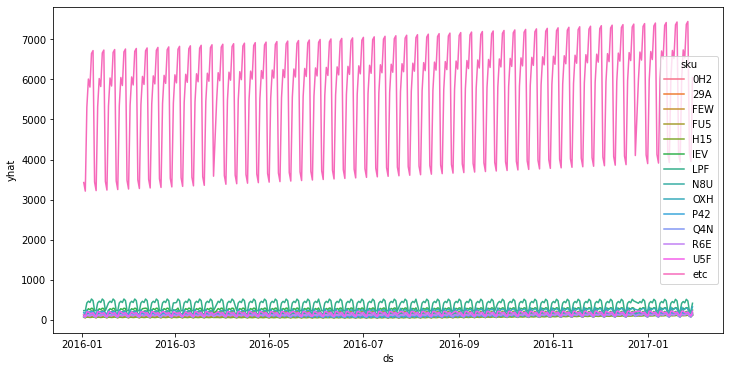

In [32]:
plt.figure(figsize = (12, 6))
sns.lineplot(data = res, x = 'ds', y = 'yhat', hue = 'sku')

# Iterator

In [33]:
users = [{'mail': 'gregorythomas@gmail.com', 'name': 'Brett Holland', 'sex': 'M', 'age': 73},
 {'mail': 'hintoncynthia@hotmail.com', 'name': 'Madison Martinez', 'sex': 'F', 'age': 29},
 {'mail': 'wwagner@gmail.com', 'name': 'Michael Jenkins', 'sex': 'M', 'age': 51},
 {'mail': 'daniel79@gmail.com', 'name': 'Karen Rodriguez', 'sex': 'F', 'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]
users

[{'mail': 'gregorythomas@gmail.com',
  'name': 'Brett Holland',
  'sex': 'M',
  'age': 73},
 {'mail': 'hintoncynthia@hotmail.com',
  'name': 'Madison Martinez',
  'sex': 'F',
  'age': 29},
 {'mail': 'wwagner@gmail.com',
  'name': 'Michael Jenkins',
  'sex': 'M',
  'age': 51},
 {'mail': 'daniel79@gmail.com',
  'name': 'Karen Rodriguez',
  'sex': 'F',
  'age': 32},
 {'mail': 'ujackson@gmail.com', 'name': 'Amber Rhodes', 'sex': 'F', 'age': 42}]

In [34]:
{k : eval(f'reduce(lambda acc, cur : acc + [cur["{k}"]], users, [])') for k in list(users[0].keys())}

{'mail': ['gregorythomas@gmail.com',
  'hintoncynthia@hotmail.com',
  'wwagner@gmail.com',
  'daniel79@gmail.com',
  'ujackson@gmail.com'],
 'name': ['Brett Holland',
  'Madison Martinez',
  'Michael Jenkins',
  'Karen Rodriguez',
  'Amber Rhodes'],
 'sex': ['M', 'F', 'M', 'F', 'F'],
 'age': [73, 29, 51, 32, 42]}

In [36]:
a = (a for a in range(10000))
print(a)

<generator object <genexpr> at 0x7fba25c23b50>


In [38]:
for _ in range(10) :
  print(next(a))

0
1
2
3
4
5
6
7
8
9


In [40]:
def get_fibo(max) :
  
  for i in range(max) :
    yield i

In [43]:
a = get_fibo(10)
for _ in range(20) :
  print(next(a))

0
1
2
3
4
5
6
7
8
9


StopIteration: ignored